# Project: Flare Quality Classificaiton

**Problem:**
   - Approach 1: Developing a Convolutional Neural Network (ConvNet) directly for classification can be effective if you have a sufficient amount of labeled data for training.
   - Approach 2: Designing a system to extract flare and smoke areas before classification can improve accuracy by focusing on relevant regions of interest.

installing libraries

In [ ]:
%pip install -r requirements.txt

Importing Libraries

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import os
import csv

### Load Images (first few)

In [5]:
import os
import cv2
import pandas as pd


def load_images(dir_path):
    """Loads image paths and labels from a directory.

    Args:
        dir_path (str): Path to the directory containing images.

    Returns:
        pandas.DataFrame: DataFrame with columns 'path' and 'label' for each image.
    """

    # Get the list of image filenames in the directory
    image_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg')][:10]
    for f in os.listdir(dir_path):
        if not f.endswith('.jpg'):
            print(f)

    # Create DataFrame with index based on number of image files
    data = pd.DataFrame([], columns=['path', 'label', 'image'], index=range(len(image_files)))

    counter = 0
    for img_file in image_files:
        # Construct the full path to the image file
        img_path = os.path.join(dir_path, img_file)

        try:
            # Attempt to read the image (handle potential errors)
            img = cv2.imread(img_path)
        except Exception as e:
            print(f"Error reading image {img_path}: {e}")
            continue  # Skip to the next image if there's an error

        # Assuming all images are smoke (adjust if needed)
        new_row = pd.Series({'path': img_path, 'label': '', "image": img}, name=counter)

        # Update the DataFrame using iloc (avoid creating extra rows)
        data.iloc[counter] = new_row
        counter += 1

    # Truncate DataFrame if fewer images than expected
    data = data.iloc[:counter]

    return data


# Define the path to the directory containing the images
image_dir = "./1000-1213 data/1000-1213 smoke data/"

# Load image data
data = load_images(image_dir)

# Print the DataFrame
data

,path,label,image
0,./1000-1213 data/1000-1213 smoke data/frame238...,,"[[[162, 148, 152], [162, 148, 152], [161, 147,..."
1,./1000-1213 data/1000-1213 smoke data/frame140...,,"[[[160, 148, 148], [163, 151, 151], [163, 151,..."
2,./1000-1213 data/1000-1213 smoke data/frame272...,,"[[[160, 145, 149], [160, 145, 149], [160, 145,..."
3,./1000-1213 data/1000-1213 smoke data/frame220...,,"[[[161, 145, 152], [161, 145, 152], [161, 145,..."
4,./1000-1213 data/1000-1213 smoke data/frame113...,,"[[[163, 148, 152], [161, 146, 150], [160, 145,..."
5,./1000-1213 data/1000-1213 smoke data/frame420...,,"[[[163, 148, 152], [163, 148, 152], [162, 147,..."
6,./1000-1213 data/1000-1213 smoke data/frame190...,,"[[[161, 149, 149], [161, 149, 149], [161, 149,..."
7,./1000-1213 data/1000-1213 smoke data/frame702...,,"[[[161, 149, 149], [161, 149, 149], [161, 149,..."
8,./1000-1213 data/1000-1213 smoke data/frame628...,,"[[[162, 147, 151], [161, 146, 150], [162, 147,..."
9,./1000-1213 data/1000-1213 smoke data/frame327...,,"[[[162, 147, 151], [162, 147, 151], [162, 147,..."


### Data Analysis on (Predictions)
 
- note: predictions calculation code is done in the last cell of the notebook

In [6]:
import pandas as pd

output_csv = 'output.csv'
df = pd.read_csv(output_csv)

df

,Image Name,Detection,Confidence,Quality
0,Image Name,Detection,Confidence,Quality
1,frame23812.jpg,smoke,0.4232463836669922,Bad Quality
2,frame14087.jpg,smoke,0.27062007784843445,Bad Quality
3,frame2727.jpg,smoke,0.3842276632785797,Bad Quality
4,frame22042.jpg,No detection,0,Good Quality
...,...,...,...,...
25400,frame20943.jpg,smoke,0.4345952570438385,Bad Quality
25401,frame2768.jpg,smoke,0.3864823281764984,Bad Quality
25402,frame5736.jpg,smoke,0.4391724169254303,Bad Quality
25403,frame4749.jpg,smoke,0.403211385011673,Bad Quality


### Data Analysis on (Labels)

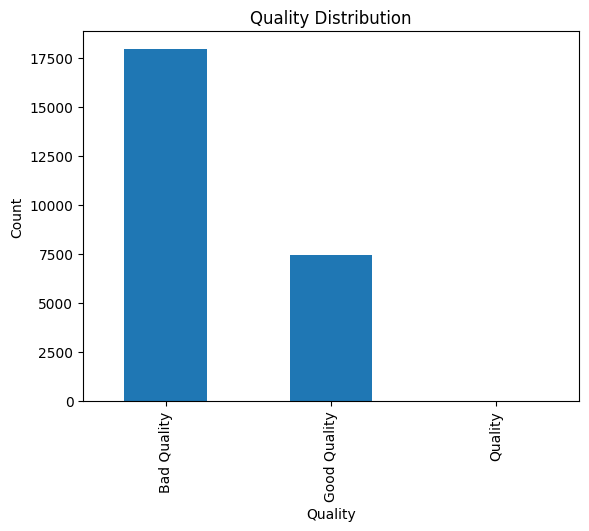

In [7]:
df['Quality'].value_counts().plot(kind='bar')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.title('Quality Distribution')
plt.show()

#### Labeling Images (*CAN RUN FOR 2-3 HOURS*)

In [8]:
def prediction(folder_path, yolo_weights, output_csv='output.csv'):
    model = YOLO(yolo_weights)

    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')][25400:25500]

    results_list = []
    processed_images = 0

    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)

        # Transform image
        img = Image.open(img_path)
        img = img.resize((640, 640))

        img_tensor = transforms.ToTensor()(img).unsqueeze_(0)

        results = model(img_tensor)

        print(f"Objects detected in {img_file}:")

        # Print results
        if len(results[0].boxes) == 0:
            print("No objects detected.")
            results_list.append([img_file, "No detection", 0, "Good Quality"])
        else:
            for i, result in enumerate(results[0].boxes):
                class_index = result.cls
                conf = float(result.conf[0].cpu().numpy())
                class_label = model.names[int(class_index)]
                # print(f"{i + 1}: {class_label} {conf:.2f}")
                results_list.append([img_file, class_label, conf, "Bad Quality"])

        processed_images += 1

        # Write to CSV after every 100 images
        if processed_images % 100 == 0:
            with open(output_csv, 'a', newline='') as file:  # Use 'a' for append mode
                writer = csv.writer(file)
                if processed_images == 100:
                    writer.writerow(["Image Name", "Detection", "Confidence", "Quality"])  # Write header only once
                writer.writerows(results_list)
                results_list = []  # Clear results list for the next batch

            print(f"Processed {processed_images} images.")  # Print message after every 100

    print(f"CSV file '{output_csv}' created successfully.")
    
yolo_weights = 'best.pt'
image_paths ="1000-1213 data/1000-1213 smoke data/"  
prediction(image_paths, yolo_weights)



0: 640x640 1 smoke, 504.4ms
Speed: 0.1ms preprocess, 504.4ms inference, 7.2ms postprocess per image at shape (1, 3, 640, 640)
Objects detected in frame3785.jpg:

0: 640x640 1 smoke, 564.6ms
Speed: 0.0ms preprocess, 564.6ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)
Objects detected in frame19581.jpg:

0: 640x640 1 smoke, 458.0ms
Speed: 0.0ms preprocess, 458.0ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)
Objects detected in frame7183.jpg:

0: 640x640 1 smoke, 651.4ms
Speed: 0.0ms preprocess, 651.4ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 640)
Objects detected in frame10561.jpg:

0: 640x640 (no detections), 442.2ms
Speed: 0.0ms preprocess, 442.2ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 640)
Objects detected in frame41960.jpg:
No objects detected.

0: 640x640 1 smoke, 517.0ms
Speed: 0.0ms preprocess, 517.0ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)
Objects detected in frame13207